# Shadow Map

In [3]:
%matplotlib widget
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import solar_angles_to_vector, solar_position, rotor_point_spacing, generate_turbine, generate_voxel_map, solve_shadow_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from matplotlib.ticker import AutoLocator
from matplotlib.colors import LogNorm
# from utils import solar_angles_to_vector, solar_position, rotor_point_spacing, generate_turbine, generate_voxel_map, solve_shadow_map

In [5]:
########
# Generate sun ray vectors
########
start_date = '2023-01-01 00:00:00'
end_date = '2023-12-30 23:59:59'
latitude = 55
longitude = 12
date_range = pd.date_range(start=start_date, end=end_date, freq="10min")
sun_pos = np.zeros([len(date_range), 2])

for i, date in enumerate(date_range):
    az, alt = solar_position(date, latitude, longitude)
    sun_pos[i,:] = az, alt


sun_pos = sun_pos[sun_pos[:,1] > np.deg2rad(5)]
sun_vec = np.zeros([len(sun_pos), 3])

for i, pos in enumerate(sun_pos):
    sun_vec[i,:] = -solar_angles_to_vector(*pos)

########
# Generate turbine points
########
diameter = 100
n_vector = np.array([1, 0])
turbine_cord = np.array([4.302e6, 3.666e6, 230])
grid_element_size = np.array([30, 30, 30])
angle = np.deg2rad(45)
r_list, n_angle = rotor_point_spacing(diameter, grid_element_size, angle)
points = generate_turbine(r_list, n_angle, n_vector, turbine_cord)

########
# Generate voxel map
########
map_boundaries = np.array([9.65, 9.75, 56.05, 56.15])
shape = [100, 100]
X, Y, voxel_map, map_array = generate_voxel_map(map_boundaries, shape)


#######
# Solve
######
from cython import solve_shadow_map
points = points.astype(np.float32)
sun_vec = sun_vec.astype(np.float32)
minBound = np.array([np.min(X), np.min(Y), np.min(map_array)], dtype = np.float32)
maxBound = np.array([np.max(X), np.max(Y), np.max(map_array)], dtype = np.float32)
voxel_map = voxel_map.astype(np.uint8)
cum_shadow_map = solve_shadow_map.solve_shadow_map_cy(points, sun_vec, minBound, maxBound, voxel_map)


In [6]:
from cython import solve_shadow_map
points = points.astype(np.float32)
sun_vec = sun_vec.astype(np.float32)
minBound = np.array([np.min(X), np.min(Y), np.min(map_array)], dtype = np.float32)
maxBound = np.array([np.max(X), np.max(Y), np.max(map_array)], dtype = np.float32)
voxel_map = voxel_map.astype(np.uint8)
cum_shadow_map = solve_shadow_map.solve_shadow_map_cy(points, sun_vec, minBound, maxBound, voxel_map)

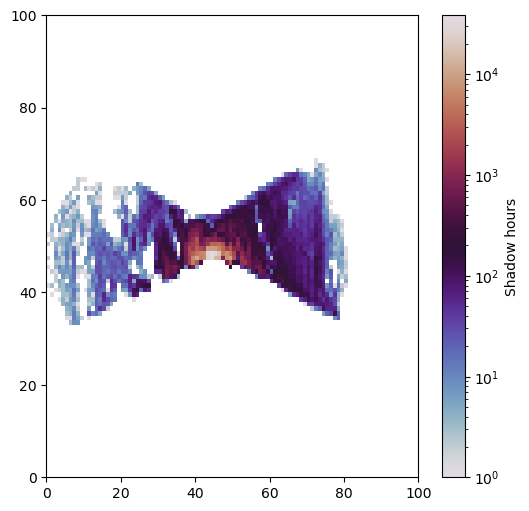

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
test_map = cum_shadow_map.copy()
ct = ax.pcolormesh(test_map, cmap = "twilight", norm=LogNorm())
plt.colorbar(ct, ax = ax, label='Shadow hours')

plt.show()

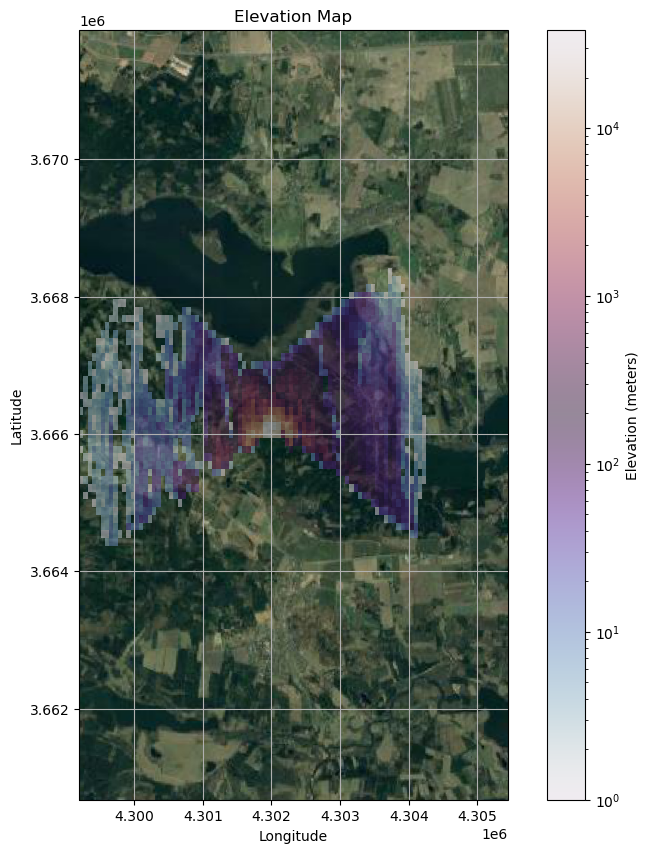

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.epsg(3035)}, figsize=(10, 10))


vmin = np.minimum(0, float('%.2g' % np.max(cum_shadow_map)))
vmax = np.maximum(0, float('%.2g' % np.max(cum_shadow_map))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

# ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], map_array, 
#                 levels = levels, vmin = vmin, vmax = vmax, extend = "both",
#                 cmap='terrain', alpha = 0.5)


ct = ax.pcolormesh(X, Y, cum_shadow_map,
                cmap='twilight', alpha = 0.5, norm = LogNorm())

plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# ax.set_extent(map_boundaries)
imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 12) # 16

# For some reason, the ticks needs to be overriden ([0]) before AutoLocator can be used.
ax.set_xticks([0], crs=ccrs.epsg(3035))
ax.set_yticks([0], crs=ccrs.epsg(3035))
ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_major_locator(AutoLocator())

plt.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()